<a href="https://colab.research.google.com/github/LoniQin/deep_learning_notebooks/blob/master/tensorflow/DogClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Classifier


## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [45]:
print(tf.__version__)

2.4.1


## Mount Google Drive
For convenience mount a Google Drive to read and write a from it and sync data to local computer.

In [2]:
from google.colab import drive
drive_path = "/content/drive"
data_path = drive_path + "/MyDrive/data"
drive.mount(drive_path)
folder_path = os.path.join(data_path, "dogs")
if not os.path.exists(folder_path):
  os.mkdir(folder_path)

Mounted at /content/drive


## Download and explore the dataset

In [3]:
ds, info = tfds.load(name="stanford_dogs",data_dir=data_path, with_info=True)

In [4]:
train = ds['train']
test = ds['test']

In [5]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [6]:
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.features["label"].int2str(7))  # Human readable version (8 -> 'cat')
print(info.features["label"].str2int('n02085782-japanese_spaniel'))

120
['n02085620-chihuahua', 'n02085782-japanese_spaniel', 'n02085936-maltese_dog', 'n02086079-pekinese', 'n02086240-shih-tzu', 'n02086646-blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-rhodesian_ridgeback', 'n02088094-afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-walker_hound', 'n02089973-english_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-irish_wolfhound', 'n02091032-italian_greyhound', 'n02091134-whippet', 'n02091244-ibizan_hound', 'n02091467-norwegian_elkhound', 'n02091635-otterhound', 'n02091831-saluki', 'n02092002-scottish_deerhound', 'n02092339-weimaraner', 'n02093256-staffordshire_bullterrier', 'n02093428-american_staffordshire_terrier', 'n02093647-bedlington_terrier', 'n02093754-border_terrier', 'n02093859-kerry_blue_terrier', 'n02093991-irish_terrier', 'n02094114-norfolk_terrier', 'n02094258-norwich_terrier', 'n02094433-yorkshi

In [7]:
print(info.features.shape)
print(info.features.dtype)
print(info.features['image'].shape)
print(info.features['image'].dtype)

{'image': (None, None, 3), 'image/filename': (), 'label': (), 'objects': {'bbox': (None, 4)}}
{'image': tf.uint8, 'image/filename': tf.string, 'label': tf.int64, 'objects': {'bbox': tf.float32}}
(None, None, 3)
<dtype: 'uint8'>


In [8]:
print(info.splits['train'].num_examples)
print(info.splits['train'].filenames)
print(info.splits['train'].num_shards)

12000
['stanford_dogs-train.tfrecord-00000-of-00004', 'stanford_dogs-train.tfrecord-00001-of-00004', 'stanford_dogs-train.tfrecord-00002-of-00004', 'stanford_dogs-train.tfrecord-00003-of-00004']
4


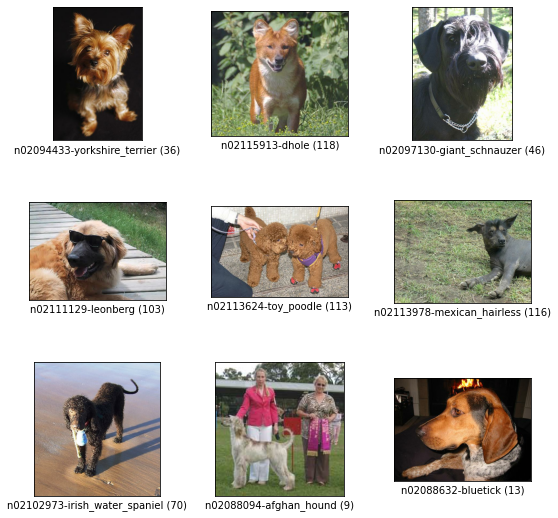

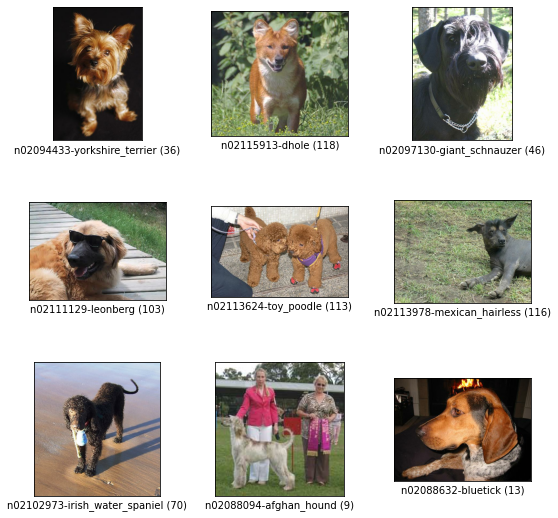

In [9]:
tfds.show_examples(train, info)

## Create a dataset

Define some parameters for the loader:

In [50]:
batch_size = 64
img_height = 128
img_width = 128

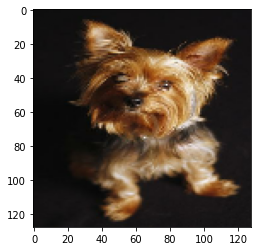

In [52]:
def normalize_img(item):
  """Normalizes images: `uint8` -> `float32`."""
  img = tf.image.resize(item['image'], size=[img_width, img_height])
  return tf.cast(img, tf.float32) / 255., item['label']

for item in train.take(1):
  img, label = normalize_img(item)
  plt.imshow(img)
  break

In [81]:
train_ds = train.map(normalize_img).batch(batch_size)
test_ds = test.map(normalize_img).batch(batch_size)

In [83]:
print(train_ds)

<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>


In [84]:
for item in train_ds:
  print(item[0].shape)
  break

(64, 128, 128, 3)


In [85]:
num_classes = info.features["label"].num_classes
class_names = info.features["label"].names
print(num_classes, class_names)

120 ['n02085620-chihuahua', 'n02085782-japanese_spaniel', 'n02085936-maltese_dog', 'n02086079-pekinese', 'n02086240-shih-tzu', 'n02086646-blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-rhodesian_ridgeback', 'n02088094-afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-walker_hound', 'n02089973-english_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-irish_wolfhound', 'n02091032-italian_greyhound', 'n02091134-whippet', 'n02091244-ibizan_hound', 'n02091467-norwegian_elkhound', 'n02091635-otterhound', 'n02091831-saluki', 'n02092002-scottish_deerhound', 'n02092339-weimaraner', 'n02093256-staffordshire_bullterrier', 'n02093428-american_staffordshire_terrier', 'n02093647-bedlington_terrier', 'n02093754-border_terrier', 'n02093859-kerry_blue_terrier', 'n02093991-irish_terrier', 'n02094114-norfolk_terrier', 'n02094258-norwich_terrier', 'n02094433-yorkshi

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [86]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

## Create the model

In [95]:
def get_model():
  model = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes)
  ])
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [96]:
model = get_model()

## Visualize the Model
Visualize the model using `summary` method and `tf.keras.utils.plot_model` method.

In [97]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_6 (RandomFlip)   (None, 128, 128, 3)       0         
_________________________________________________________________
random_rotation_6 (RandomRot (None, 128, 128, 3)       0         
_________________________________________________________________
random_zoom_6 (RandomZoom)   (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 32)      

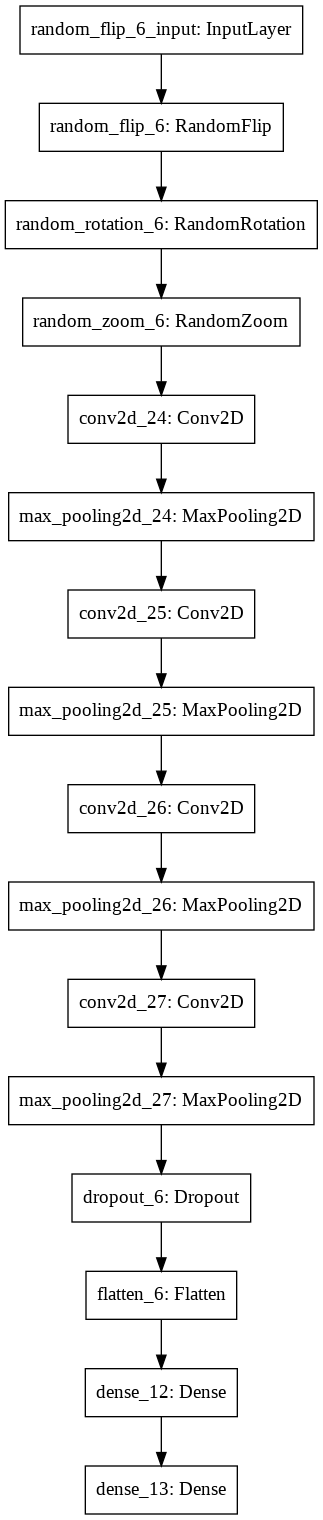

In [98]:
tf.keras.utils.plot_model(model)

In [99]:
weights_path = os.path.join(folder_path, "best_weights_4.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path)

In [100]:
if os.path.exists(weights_path):
  model.load_weights(weights_path)

In [101]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=test_ds,
  batch_size=batch_size,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/30
188/188 [==============================] - 23s 118ms/step - loss: 4.7904 - accuracy: 0.0070 - val_loss: 4.7326 - val_accuracy: 0.0160
Epoch 2/30
188/188 [==============================] - 22s 118ms/step - loss: 4.6190 - accuracy: 0.0211 - val_loss: 4.4452 - val_accuracy: 0.0360
Epoch 3/30
188/188 [==============================] - 22s 117ms/step - loss: 4.3333 - accuracy: 0.0419 - val_loss: 4.2585 - val_accuracy: 0.0570
Epoch 4/30
188/188 [==============================] - 22s 118ms/step - loss: 4.1847 - accuracy: 0.0628 - val_loss: 4.1883 - val_accuracy: 0.0611
Epoch 5/30
188/188 [==============================] - 22s 117ms/step - loss: 4.0756 - accuracy: 0.0773 - val_loss: 4.0922 - val_accuracy: 0.0780
Epoch 6/30
188/188 [==============================] - 22s 118ms/step - loss: 3.9778 - accuracy: 0.0894 - val_loss: 4.0664 - val_accuracy: 0.0832
Epoch 7/30
188/188 [==============================] - 22s 117ms/step - loss: 3.8857 - accuracy: 0.1037 - val_loss: 4.0090 - val_ac

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

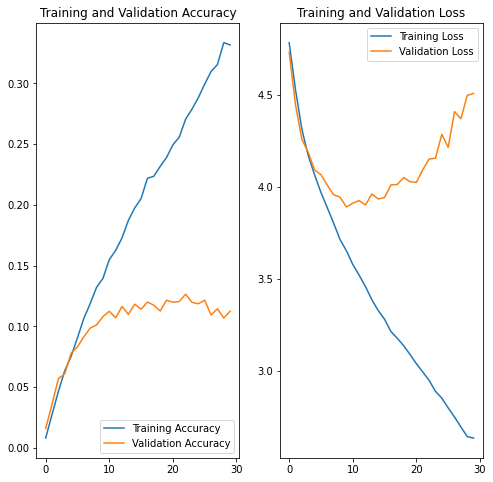

In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Conclusions
This dataset overfits a lot. There can be many ways to improve:
1. Find a better archicture
2. Use transfer learing method to train the data
3. Use bounding box information to get the location of dogs
4. Find a better data augmentation method